In [10]:
import pandas as pd
import json
import numpy as np
# secondlastentry & lastentry correspond to '_id.$oid' from gameplays db
gameplays = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\gameplays.json").readlines()).apply(json.loads))
questionresponses = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\questionresponses.json").readlines()).apply(json.loads))

d = {
  "A": "secondlastentry",
  "B": "lastentry"
}
def expand_AB(x):
    if x in d:
        return d[x]
    else:
        return x

def expand_BOTH (x):
    if x == "both":
        return ["secondlastentry","lastentry"]
    else:
        return x
    
def replace_column(db, column, function):
    db[column] = db[column].apply(function)

columns = ["fun", "challenging", "frustrating"]

def expand_AB_all():
    for column in columns:
        replace_column(questionresponses, column, lambda x: expand_AB(x))

def expand_BOTH_all():
    for column in columns:
        replace_column(questionresponses, column, lambda x: expand_BOTH(x))
expand_AB_all()
expand_BOTH_all()
questionresponses

def explode_questionresponses():
    # explode questionresponses on secondlastentry and lastentry, + indicate which_entry 
    q = questionresponses
    q['entry'] = q[['secondlastentry', 'lastentry']].values.tolist()
    q = q.explode('entry')
    q['original_index'] = q.index
    q['which_entry'] = np.where((q['entry'] == q['secondlastentry']), 'secondlastentry', 'lastentry')
    q = q[['entry', 'which_entry', 'fun', 'challenging', 'frustrating']]
    q
    
    # transform columns
    columns = ['fun', 'challenging', 'frustrating']
    for column in columns:
        # turn every element into list, even if its a single element
        q[column] = q[column].apply(lambda x: x if(isinstance(x, list)) else [x])
        #check if the value corresponds to the correct entry
        kwargs = {column : lambda x: [a in b for a,b in zip(q['which_entry'],q[column])]}
        q = q.assign(**kwargs)
    q[['entry', 'fun', 'challenging', 'frustrating']]
    
    # append gameplay data
    a = q.merge(gameplays, left_on='entry', right_on='_id.$oid')
    return a
a = explode_questionresponses()

# converst collisionObstacle to ints
dict = {'CACTUS_LARGE':0, 'CACTUS_SMALL':1, 'PTERODACTYL':2}
if(isinstance(a['collisionObstacle.typeConfig.type'][0], str)):
    a['collisionObstacle.typeConfig.type'] = a['collisionObstacle.typeConfig.type'].replace(dict)

a['collisionObstacle.typeConfig.type']

0       0
1       2
2       2
3       1
4       2
       ..
1041    2
1042    1
1043    1
1044    1
1045    0
Name: collisionObstacle.typeConfig.type, Length: 1046, dtype: int64

[[2.85714286e-01 1.06668571e+04]
 [5.69696970e-01 3.12737374e+02]
 [5.10204082e-01 3.25636735e+03]]


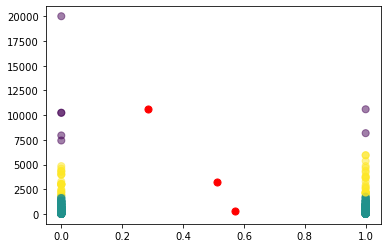

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df = a[[
          'fun',
          'challenging',
          'frustrating',
          'actualDistance',
          'parameters.SPEED', 
          'parameters.ACCELERATION',
          'parameters.MIN_GAP',
          'parameters.NIGHT_MODE_ENABLED', 
          'parameters.NIGHT_MODE_DISTANCE',
          'parameters.CLEAR_TIME', 
          'parameters.MAX_OBSTACLE_LENGTH',
          'parameters.MAX_SPEED',
          'parameters.MAX_GAP', 
          'actualDistance', 
          'collisionObstacle.typeConfig.type',
          'nr_jumps',
          'invertedGameOver'
    ]]
df = a[[
    'fun',
    'actualDistance'
]]
kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['fun'], df['actualDistance'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()